In [36]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor

In [37]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.5)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", r2_score(y_true, y_pred))
    print("RMSE: ", (mean_squared_error(y_true, y_pred)) ** 0.5)

In [38]:
# Read csv into dataframe.
df = pd.read_csv('Data/210907_Essay_score_cleaned_2.csv')

In [39]:
# Deal with isna's and dtypes.
cols = ['Grade', 'Major', 'Field']
for c in cols:
    df[c] = df[c].fillna('N/A')
df.Grade = df.Grade.astype(str)
df = df.drop(['Unnamed: 0', 'Code'], axis=1)

In [40]:
# Subset X and y.
X = df.drop(['VST'], axis=1).copy()
y = df.VST.copy()

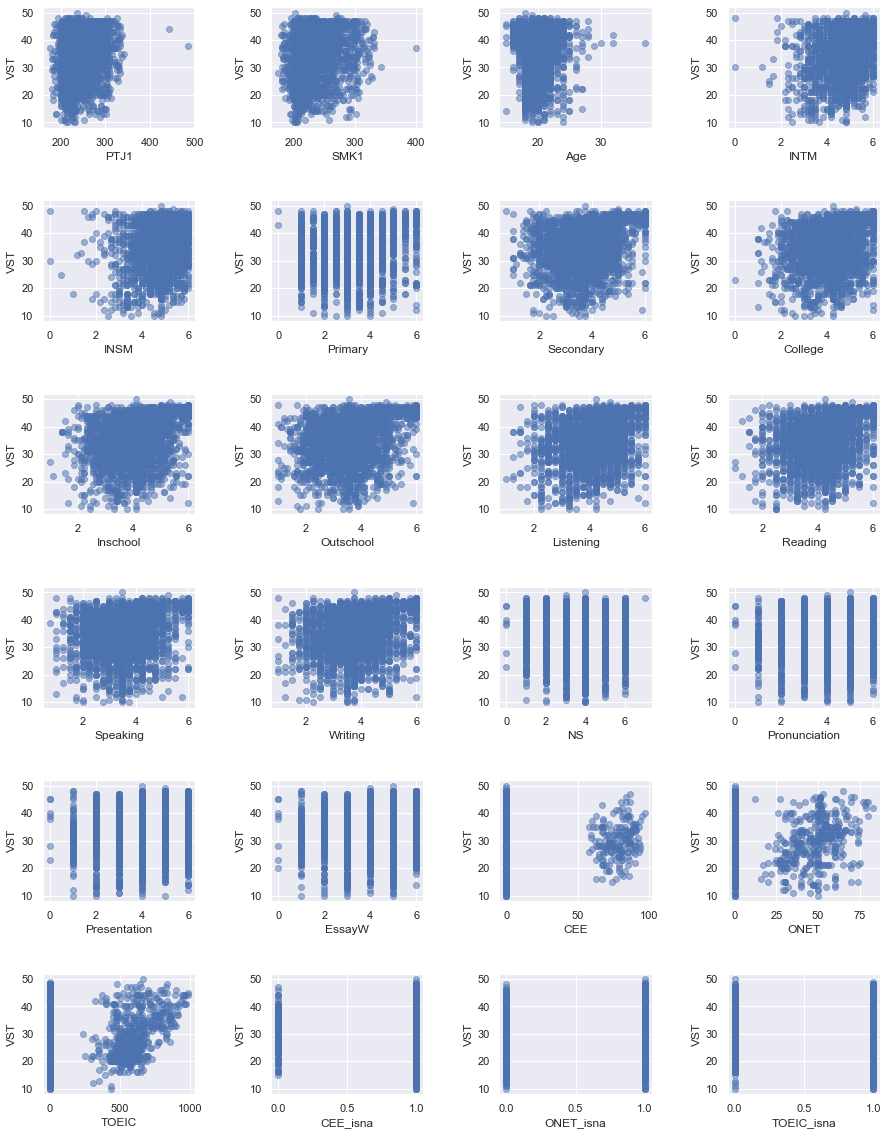

In [41]:
# Quick EDA for feature analysis.
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'VST', data=df, ncol=4, figsize=(15, 20))

In [42]:
# Get dummies for all categorical types, including Grades (ordinal)
X = pd.get_dummies(X, dtype='int64')
X.shape

(2600, 190)

In [43]:
# Train Test split. Check their shapes and types
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(1950, 190) (650, 190) (1950,) (650,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [44]:
# Random Forest Regressor - initialize
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Parameter grid for gridsearch
params = {
    'n_estimators': [int(n) for n in np.logspace(1,3,5)],
    'max_depth': [None, 10, 20, 30]
}

# 5-fold CV Grid Search, fit, and show top five CV stats. Commented out for run-throughs
#rf_grid_cv = GridSearchCV(rf, params, cv=5, n_jobs=-1)
#rf_grid_cv.fit(X_train, y_train)
#print(rf_grid_cv.best_params_)
#pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

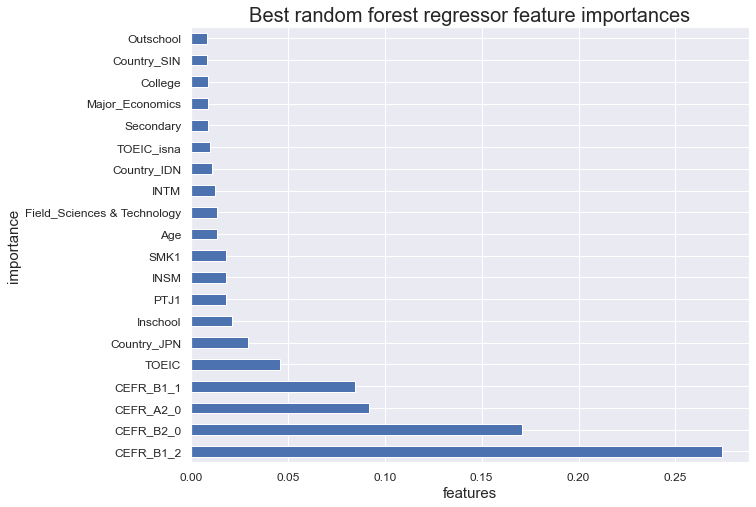

In [66]:
# Manually store best RF estimator as rf_best. Fit to training set.
rf_best = RandomForestRegressor(random_state=42, n_estimators=1000, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Plot the top 20 feature importances.
plt.subplots(figsize=(10, 8))
imps = rf_best.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:20]
_ = rf_feat_imps.plot(kind='barh', fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances', fontsize=20);
plt.show()

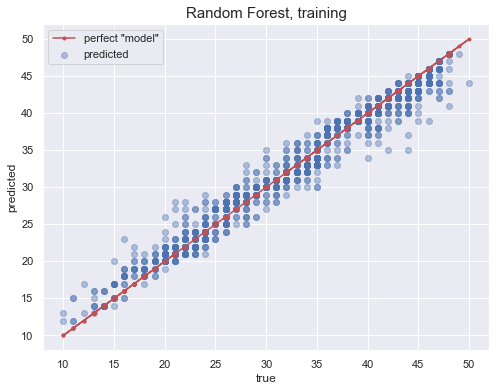

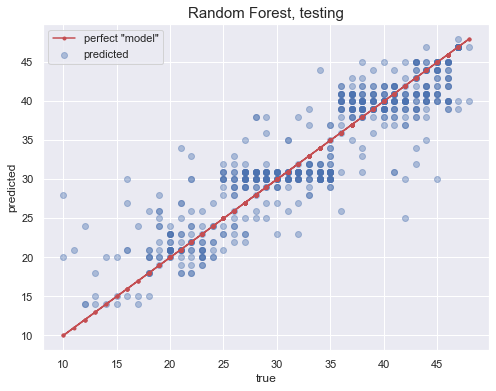

In [102]:
# Predict Training and Test sets with Rf model
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, np.round(y_tr_rf_pred))
pred_plot("Random Forest, testing", y_test, np.round(y_te_rf_pred))

In [106]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.8249770506208017
RMSE:  3.6748612880153515


In [59]:
# XG Boost - initialize.
xg = XGBRegressor(objective='reg:linear', seed=42)
xgb.set_config(verbosity=0)

# Parameter grid for grid searching.
params = {
    'max_depth': range(1, 8),
    'n_estimators': [int(n) for n in np.logspace(start=1, stop=3, num=5)],
    'learning_rate': [n for n in np.logspace(start=-3, stop=0, num=4)]
}

# 5-fold CV Grid search, fit, and print CV stats for top five estimators
#xg_grid_cv = GridSearchCV(xg, params, cv=5, n_jobs=-1)
#xg_grid_cv.fit(X_train, y_train)
#print(xg_grid_cv.best_params_)
#pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

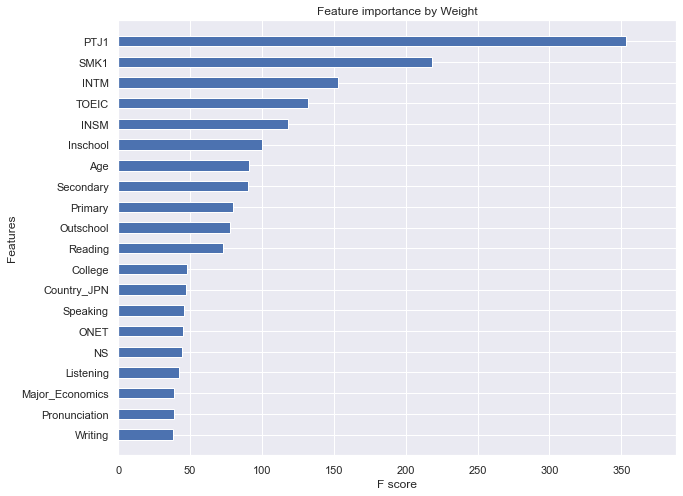

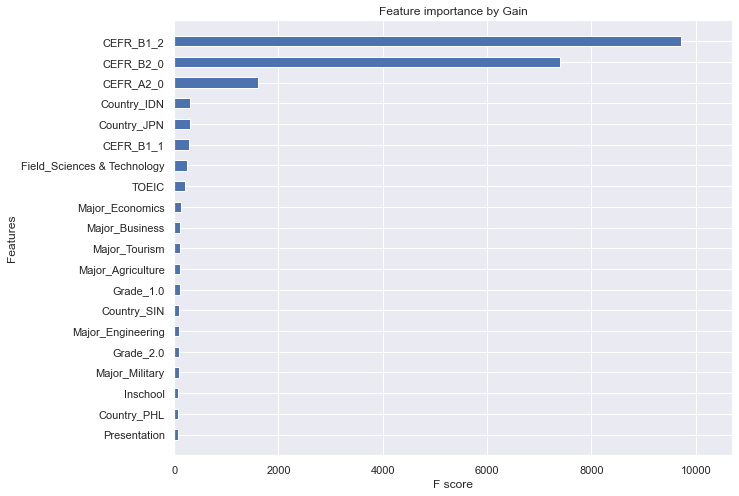

In [76]:
# Manually store best XG Boost model as xg_best. Fit to training set.
xg_best = XGBRegressor(objective='reg:linear', learning_rate=0.1, max_depth=6, n_estimators=100, seed=42)
xg_best.fit(X_train, y_train)

# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

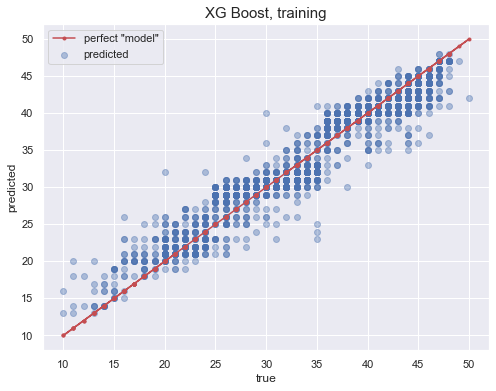

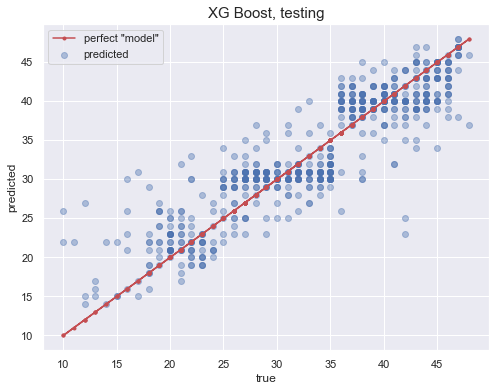

In [101]:
# Predict on Training and Test sets using XG Boost model
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, np.round(y_tr_xg_pred))
pred_plot("XG Boost, testing", y_test, np.round(y_te_xg_pred))

In [105]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.816198819481559
RMSE:  3.7658897369523863


In [81]:
# Initialize pipeline for optional StandardScaler followed by Lasso regression
scaler = StandardScaler()
lasso = Lasso(random_state=42)
pipe = make_pipeline(scaler, lasso)

# Parameter grid for pipeline - scaler is optional.
params = {
    'standardscaler': [StandardScaler(), None],
    'lasso__alpha': [n for n in np.logspace(-5,3,20)]
}

# 5-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
#lasso_grid_cv = GridSearchCV(pipe, params, cv=5, n_jobs=-1)
#lasso_grid_cv.fit(X_train, y_train)
#print(lasso_grid_cv.best_params_)
#pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

In [82]:
# Set lasso_best to alpha=0.01 - this is very close to top CV result. Fit to training set.
lasso_best = Lasso(alpha=0.01, random_state=42)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.01, random_state=42)

In [91]:
# For plotting purposes - keep only the coefficients of absolute value > 0.2 to keep the plot visually comprehensible
lasso_coefs = pd.DataFrame(lasso_best.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs = lasso_coefs[abs(lasso_coefs.coef) > 0.2]

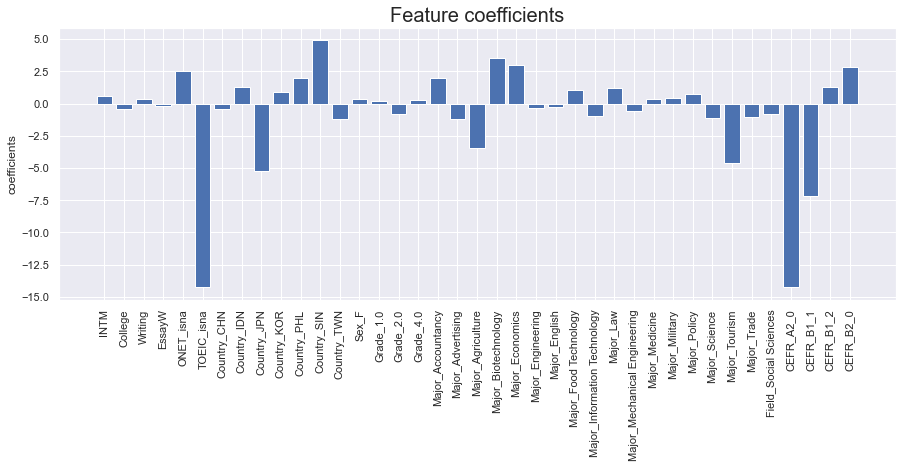

In [92]:
# Plot feature coefficients of Lasso regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs.index, lasso_coefs.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

In [93]:
# Store means of non-zero entries of each column to list means. This is for scaling the Lasso coefficients.
means = []
for c in X_train.columns:
    means.append(X_train[X_train[c] != 0][c].mean())

# For plotting purposes - keep only the scaled coefficients of absolute value > 0.2 to keep the plot visually comprehensible
scaled_coefs = pd.DataFrame(lasso_best.coef_ * means, index=X_train.columns, columns=['scaled_coef']).fillna(0)
scaled_coefs = scaled_coefs[abs(scaled_coefs.scaled_coef) > 0.2]

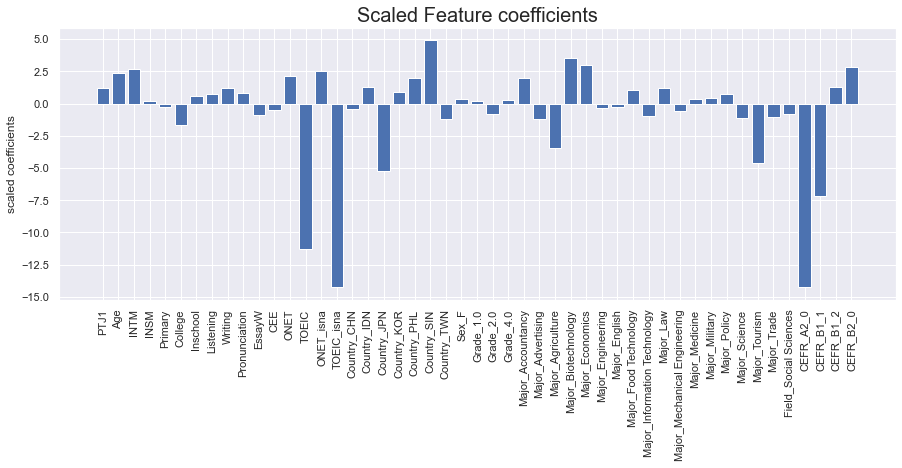

In [95]:
# Plot scaled feature coefficients of Lasso Regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(scaled_coefs.index, scaled_coefs.scaled_coef)
plt.xticks(rotation='vertical')
plt.ylabel('scaled coefficients')
plt.title('Scaled Feature coefficients', fontsize=20)
plt.show()

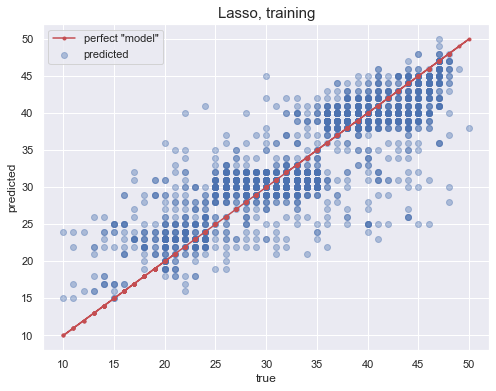

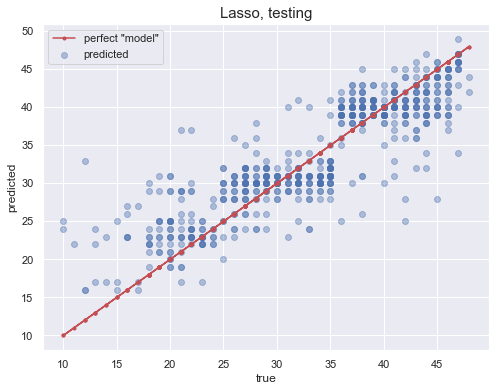

In [103]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = lasso_best.predict(X_train)
y_te_lasso_pred = lasso_best.predict(X_test)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, np.round(y_tr_lasso_pred))
pred_plot("Lasso, testing", y_test, np.round(y_te_lasso_pred))

In [104]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.7638483850625923
RMSE:  4.268633925744357


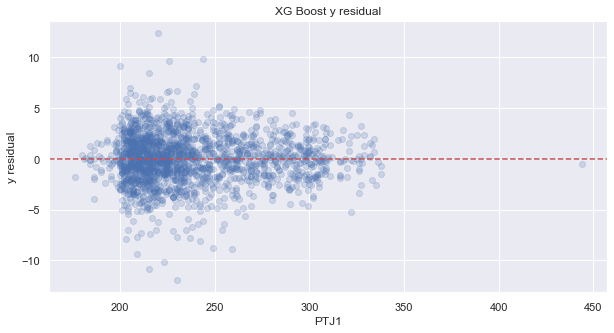

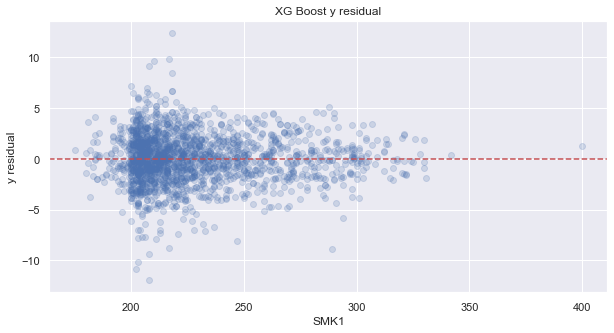

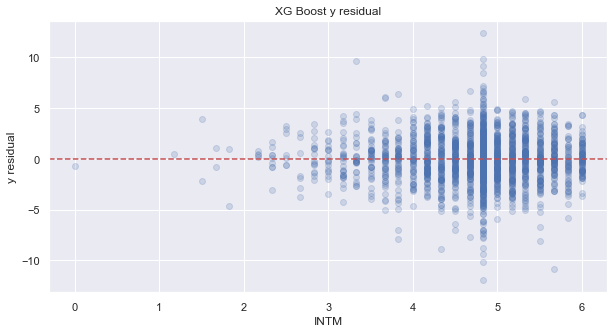

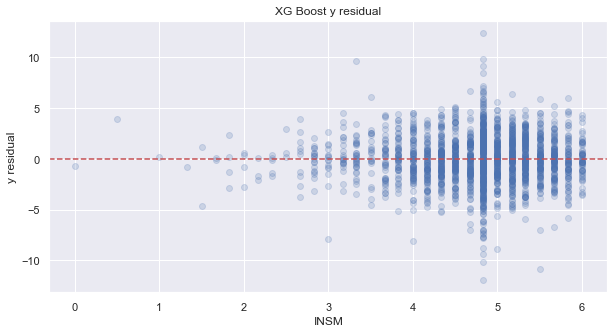

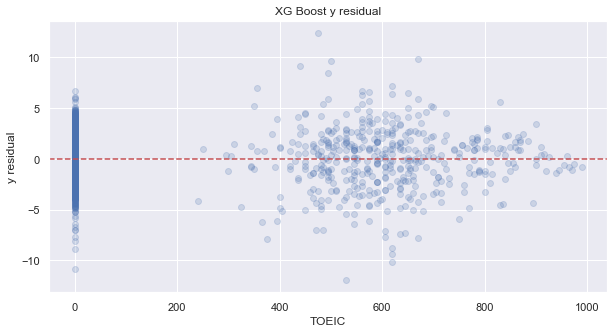

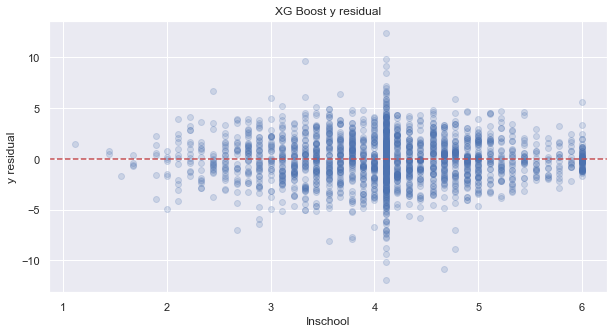

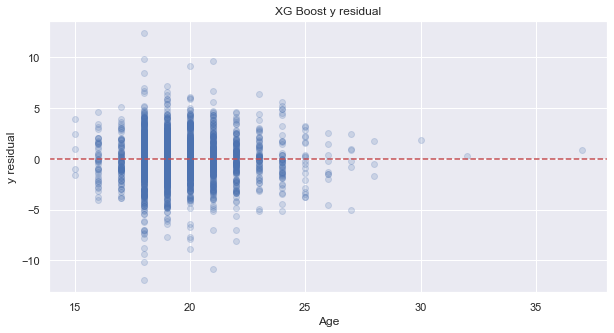

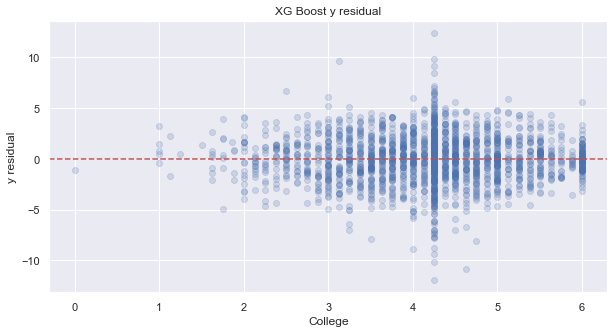

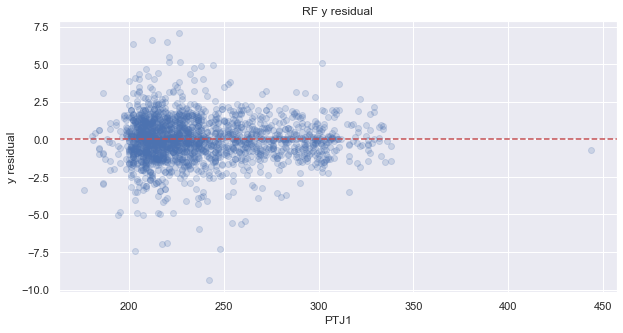

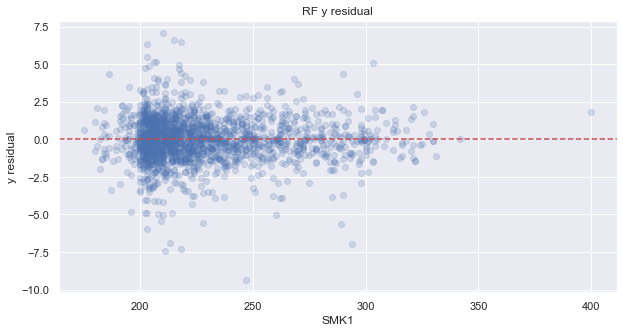

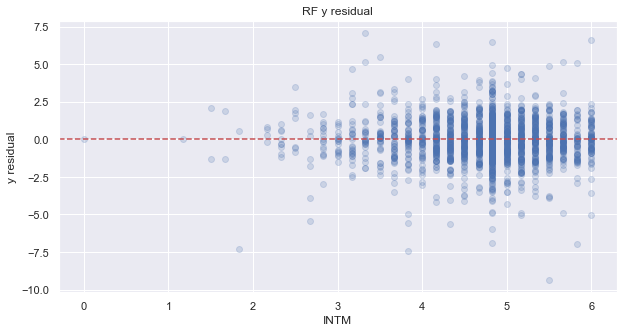

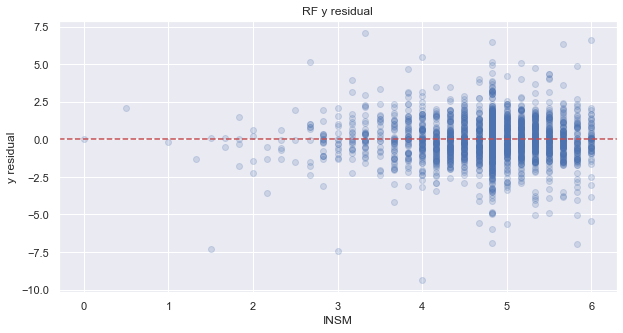

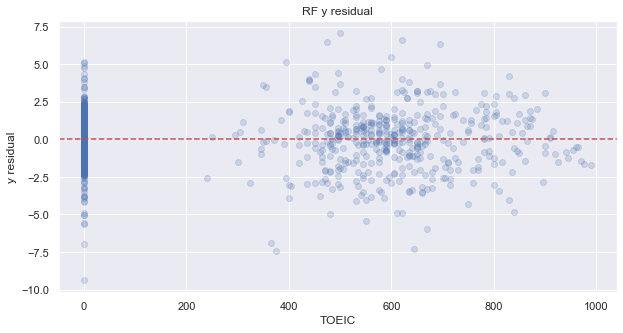

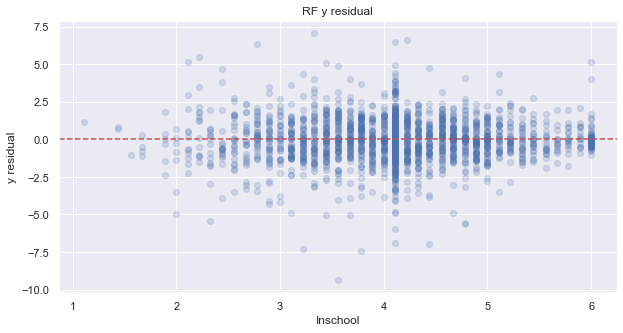

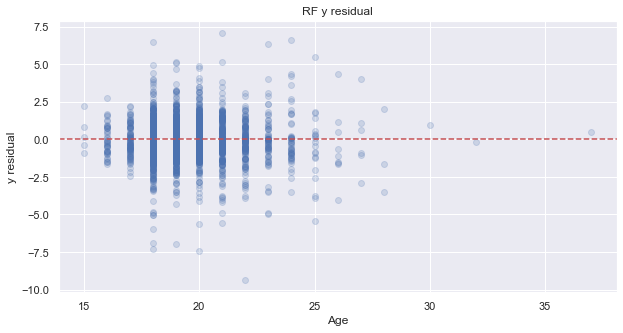

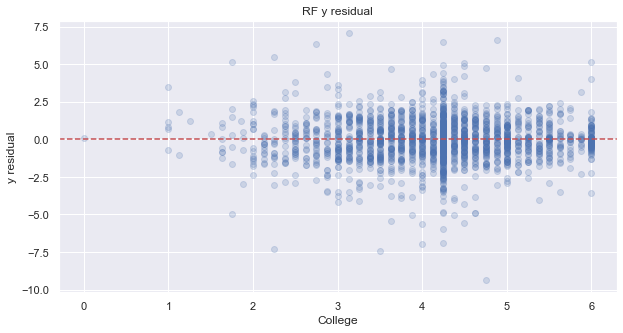

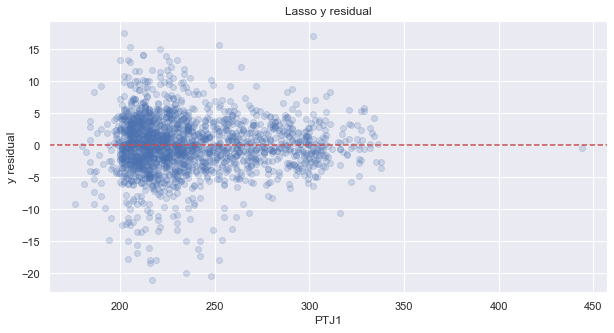

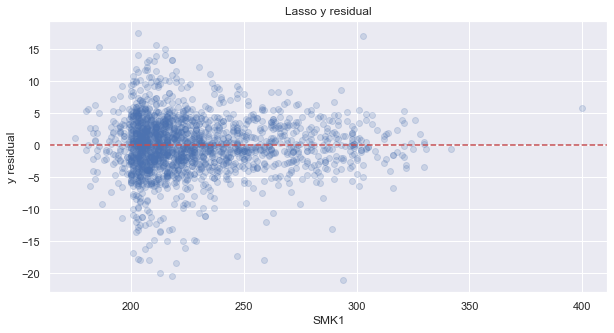

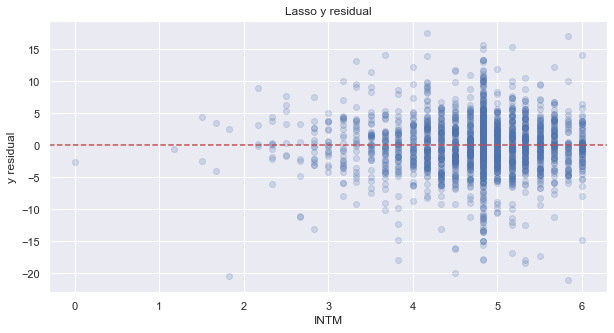

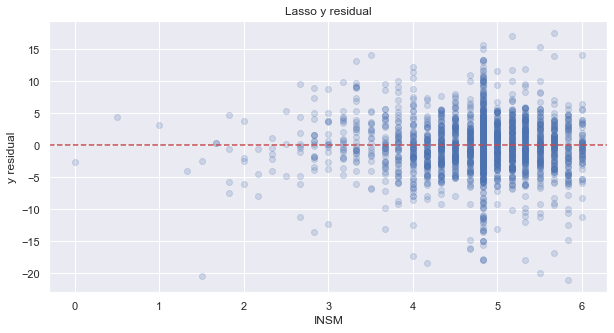

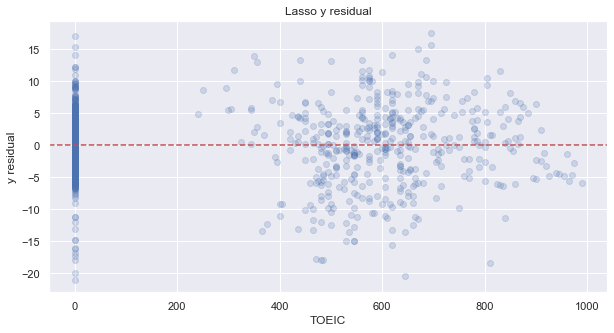

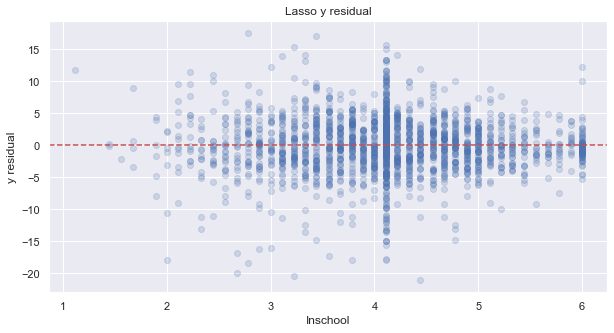

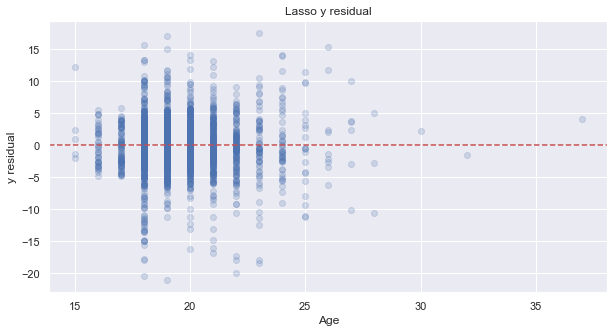

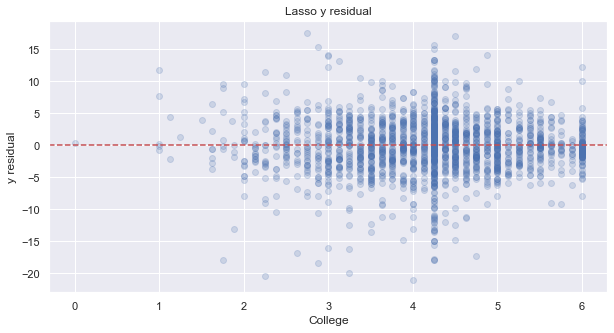

In [125]:
# Highest weight continuous columns for XG Boost
cols = ['PTJ1', 'SMK1', 'INTM', 'INSM', 'TOEIC', 'Inschool', 'Age', 'College']

# XG Boost Training prediction residuals
y_tr_xg_res = y_tr_xg_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_xg_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('XG Boost y residual')
    plt.show()
    
# RF Training prediction residuals
y_tr_rf_res = y_tr_rf_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_rf_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('RF y residual')
    plt.show()
    
# Lasso Training prediction residuals
y_tr_lasso_res = y_tr_lasso_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_lasso_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('Lasso y residual')
    plt.show()